#### 1. 利用波段运算获得MNDWI水体指数值。
#### 2. 通过直方图阈值分割获得水体提取结果。
备注：实验影像共具有6个波段，1-6波段分别为蓝波段、绿波段、红波段、近红外波段、短波红外1波段、短波红外2波段。

In [16]:
from osgeo import gdal
from osgeo import osr
import numpy as np
import matplotlib.pyplot as plt


In [17]:
path_img = 'data/Section_5/rsimg_chenggong_wgs84.tif'


In [18]:
dset = gdal.Open(path_img)
img_array = dset.ReadAsArray()
print(img_array.shape)


(6, 1555, 1573)


#### MNDWI = (Green - SWIR) / (Green + SWIR)
参考：Xu, H. "Modification of Normalised Difference Water Index (NDWI) to Enhance Open Water Features in Remotely Sensed Imagery." International Journal of Remote Sensing 27, No. 14 (2006): 3025-3033." 


In [19]:
band_green = dset.GetRasterBand(2).ReadAsArray().astype(np.float16)
band_swir = dset.GetRasterBand(5).ReadAsArray().astype(np.float16)
mndwi = (band_green - band_swir)/(band_green+band_swir+0.000001)


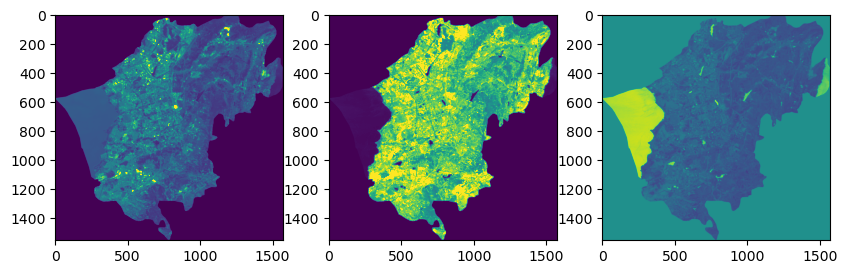

In [20]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.imshow(band_green, vmax=3000, vmin=0)
plt.subplot(1,3,2); plt.imshow(band_swir, vmax=3000, vmin=0)
plt.subplot(1,3,3); plt.imshow(mndwi, vmax=1, vmin=-1)


#### 直方图统计及影像阈值分割

In [22]:
id_valid = np.where(band_green != 0)
id_nodata = np.where(band_green == 0)
id_valid


(array([   0,    0,    0, ..., 1553, 1554, 1554]),
 array([1180, 1181, 1182, ...,  788,  786,  787]))

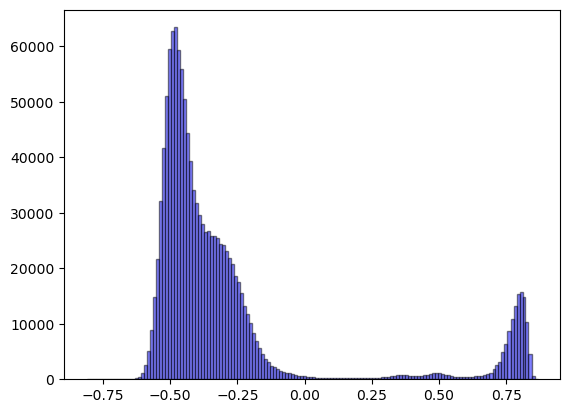

In [23]:
n, bins, patches = plt.hist(mndwi[id_valid], bins=150, ec="black", fc="blue", alpha=0.5)


In [24]:
### 根据直方图确定分割阈值为0.25
thre = 0.25
mndwi_seg = np.where(mndwi>0.25, 1, 0)
mndwi_seg[id_nodata] = -1



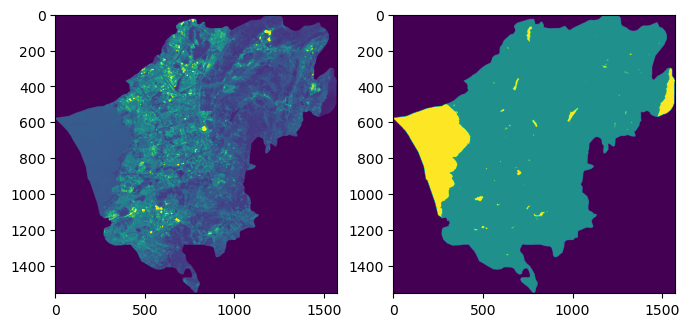

In [27]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(band_green, vmax=3000, vmin=0)
plt.subplot(1,2,2); plt.imshow(mndwi_seg, vmin=-1, vmax=1)


### 写出阈值分割结果

In [28]:
driver = gdal.GetDriverByName("GTiff")   ### 创建.tif文件驱动
outdset = driver.Create('data/Section_5/rsimg_chenggon_mndwi_thre025.tif', xsize=mndwi_seg.shape[1], \
                                ysize=mndwi_seg.shape[0], bands=1, eType=gdal.GDT_Int16)  ### 创建空的.tif数据
outdset.SetGeoTransform(dset.GetGeoTransform())    ### 设置地理转换参数
outdset.SetProjection(dset.GetProjection())        ### 设置投影
outdset.WriteArray(mndwi_seg)      ### 将np.array()数组写入波段1
outdset = None                     ### 关闭.tif文件驱动

